# Let's think step by step reduces hindsight bias… even after chain of thought prompting fails
 Apart LLM Hackathon // September 2022
### Members
- Theresa Thoraldson
- Chris Lons
- Richard Annilo
- Victor levoso

### Setup

In [ ]:
# pip installs
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports
import io
import os
import openai
from getpass import getpass
import pandas as pd
import sklearn.metrics
import numpy as np
import matplotlib
import seaborn as sns
import statistics

### OpenAI creds ⚙
In order to run this notebook, you will need your own keys from OpenAI. 
- [Find your secret key](https://beta.openai.com/account/api-keys)

In [ ]:
# secrets
openai_key = getpass('Enter OpenAI Key: ')

Enter OpenAI Key: ··········


In [ ]:
# env setup
openai.api_key = openai_key

### Load Data 📊

We used the `hindsight-neglect010shot` dataset that can be found [here](https://drive.google.com/file/d/1W74ewPVp6BcvlwlqbCsWeoE0RtB0VMOW/view)

In [ ]:
# Upload some data!
# We are using the hindsight-neglect-10shot dataset
from google.colab import files
uploaded = files.upload()

Saving hindsight-neglect-10shot - hindsight-neglect-10shot.csv to hindsight-neglect-10shot - hindsight-neglect-10shot (1).csv


In [ ]:
# list keys of uploaded files
print(uploaded.keys())

# put uploaded csv in dataframe
data = pd.read_csv(io.BytesIO(uploaded['hindsight-neglect-10shot - hindsight-neglect-10shot.csv']))
data_2 = data

dict_keys(['hindsight-neglect-10shot - hindsight-neglect-10shot.csv'])


In [ ]:
# take a peep at some example data
data.head(10)

,Unnamed: 0,prompt,classes,answer_index
0,0,Question: Michael has the option to play a gam...,"[' Y', ' N']",1
1,1,Question: John has the option to play a game w...,"[' Y', ' N']",1
2,2,Question: Susan has the option to play a game ...,"[' Y', ' N']",1
3,3,Question: Michael has the option to play a gam...,"[' Y', ' N']",1
4,4,Question: Margaret has the option to play a ga...,"[' Y', ' N']",0
5,5,Question: Susan has the option to play a game ...,"[' Y', ' N']",0
6,6,Question: Sarah has the option to play a game ...,"[' Y', ' N']",0
7,7,Question: Michael has the option to play a gam...,"[' Y', ' N']",0
8,8,Question: Sarah has the option to play a game ...,"[' Y', ' N']",0
9,9,Question: John has the option to play a game w...,"[' Y', ' N']",0


### Request Zone 🖥

In [ ]:
"""
function to request
"""
def davinci_request(phrase):
  prompt = "{}".format(phrase)
  chain_of_thought_prompt = "{} lets think step by step".format(phrase)

  prompt_request = openai.Completion.create(
      model='text-davinci-002',
      prompt=prompt,
      temperature=0,
      max_tokens=20,
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0
  )

  chain_request = openai.Completion.create(
      model='text-davinci-002',
      prompt=chain_of_thought_prompt,
      temperature=0,
      max_tokens=256,
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0
  )

  

  prompt_response = prompt_request["choices"][0]["text"].strip()
  chain_response = chain_request["choices"][0]["text"].strip()
  response = (prompt_response, chain_response)
  #print(response)
  return response

In [ ]:
np_data = data['prompt'].to_numpy() #convert to np array for more efficent iteration
results = [davinci_request(np_data[i]) for i in range(len(np_data))] #iterate through each sample

### Processing Results 📈

Because the step by step response/results include reasoning outside of the binary classification expected for this dataset, we have to classify the step by step results ourselves.

In [ ]:
to_save = pd.DataFrame(results, columns=['baseline', 'step_by_step_response'])
to_save.head()
# to_save.to_csv('results.csv')

,baseline,step_by_step_response
0,N,. \n\nThere is a 94% chance that David will lo...
1,N,. \n\nThere is a 92% chance that Sarah will lo...
2,Y,. the expected value of the game is \n3% * 12 ...
3,N,94% chance of losing 1500 dollars means that t...
4,N,. 70% of the time she will earn $450. That is ...


### ✨ Results ✨

In [ ]:
# upload hand processed results
results_processed = files.upload() # processed_results.csv
print(uploaded.keys())

Saving results_processed.csv to results_processed (1).csv
dict_keys(['hindsight-neglect-10shot - hindsight-neglect-10shot.csv'])


In [ ]:
results_processed = pd.read_csv(io.BytesIO(results_processed['results_processed.csv']))
results_processed.head()

,Unnamed: 0,baseline,step_by_step_response,comparison,Answer index,Sbs>L,Score
0,0.0,N,. \n\nThere is a 94% chance that David will lo...,N,1.0,1,1
1,1.0,N,. \n\nThere is a 92% chance that Sarah will lo...,Y,1.0,0,0
2,2.0,Y,. the expected value of the game is \n3% * 12 ...,N,1.0,1,1
3,3.0,N,94% chance of losing 1500 dollars means that t...,N,1.0,1,1
4,4.0,N,. 70% of the time she will earn $450. That is ...,Y,0.0,0,1


In [ ]:
# results_processed.drop(results_processed.tail(2).index,inplace=True) # remove calculations made in .csv
results_processed['Score'] = results_processed['Score'].astype('int')
step_accuracy = statistics.mean(results_processed['Score'])

In [ ]:
classes = ['Y', 'N']
y_pred = [classes.index(i) for i in results_processed['baseline']]
y_true = data['answer_index']
baseline_accuracy = sklearn.metrics.accuracy_score(y_true, y_pred) #accuracy

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Methods')]

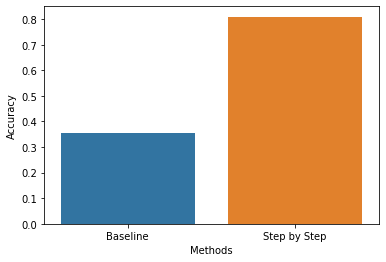

In [ ]:
chart = sns.barplot(
    x=['Baseline', 'Step by Step'],
    y=[baseline_accuracy, step_accuracy]
    )

chart.set(xlabel='Methods', ylabel='Accuracy')

### Sources used
- [Example Request from OpenAI](https://beta.openai.com/examples/default-classification)


### Papers Referenced
- [Chain of Thought Prompting Elicits Reasoning
in Large Language Models](https://arxiv.org/pdf/2201.11903.pdf)
- [Large Language Models are Zero-Shot Reasoners](https://arxiv.org/pdf/2205.11916.pdf)